In [ ]:
from typing import Any, Dict, Optional
from typing_extensions import TypedDict
from dataclasses import dataclass, field

import pandas as pd
import duckdb
from dotenv import load_dotenv

load_dotenv()

path_to_csv: str = "/Users/patrickwalsh/dev/dataly-backend/data/titanic/train.csv"

@dataclass
class Insightly:
    """
    A class to represent a connection to a DuckDB database.
    
    Attributes
    ----------
    conn : duckdb.DuckDBPyConnection
        The DuckDB connection object.
    """
    conn: duckdb.DuckDBPyConnection = field(default_factory=duckdb.connect)
    db_name: Optional[str] = field(default="memory")
    tables: list[str] = field(default_factory=list)
    
    # reading the CSV file into a DuckDB table
    def read_csv_to_duckdb(
        self,
        path_to_csv: str,
        table_name: str = "titanic"
    ) -> None:
        """
        Reads a CSV file into a DuckDB table.
        
        Parameters
        ----------
        conn : duckdb.DuckDBPyConnection
            The DuckDB connection object.
        path_to_csv : str
            The path to the CSV file.
        table_name : str, optional
            The name of the table to create in DuckDB (default is "titanic").

        Returns
        -------
        None
        """
        # self.db_name = table_name
        self.conn.execute(
            f"""
            CREATE TABLE IF NOT EXISTS {table_name} AS
            SELECT * FROM '{path_to_csv}'
            """
        )
        # set the list of tables for the database for later usage
        tables_tuple = self.conn.execute("PRAGMA show_tables;").fetchall()
        print(tables_tuple)
        self.tables = [t[0] for t in tables_tuple]

    # reading the CSV file into a DuckDB table
    def read_mysql_db(
        self,
        path_to_db: str,
        db_name: str
    ) -> None:
        """
        Reads a CSV file into a DuckDB table.
        
        Parameters
        ----------
        conn : duckdb.DuckDBPyConnection
            The DuckDB connection object.
        path_to_db : str
            The path to the db file.
        db_name : str, optional
            The name of the table to create in DuckDB (default is "titanic").

        Returns
        -------
        None
        """
        self.db_name = db_name
        query: str = f"""
            CALL sqlite_attach('{path_to_db}');
            ATTACH '{path_to_db}' AS {db_name} (TYPE sqlite);
        """
        print(query)
        self.conn.execute(query)

        # set the list of tables for the database for later usage
        tables_tuple = self.conn.execute("PRAGMA show_tables;").fetchall()
        self.tables = [t[0] for t in tables_tuple]

    def retrieve_table(
        self,
        table_name: str
    ) -> duckdb.DuckDBPyRelation:
        """
        Retrieves a DuckDB table as a relation.
        
        Parameters
        ----------
        conn : duckdb.DuckDBPyConnection
            The DuckDB connection object.
        table_name : str, optional
            The name of the table to retrieve (default is "titanic").

        Returns
        -------
        duckdb.DuckDBPyRelation
            The relation representing the DuckDB table.
        """
        return self.conn.table(table_name)

    # get the schema using duckdb
    def get_schema(self, table_name: Optional[str] = None) -> Dict[str, Any]:
        # get the schema with each of the table names
        tables = [table_name] if table_name is not None else self.tables
        schemas = {}

        for table in tables:
            # Fetch column info
            info = self.conn.execute(f"PRAGMA table_info('{self.db_name}.{table}')").fetchall()
            
            # Format into a string
            schema_string = ", ".join(f"{col[1]} {col[2]}" for col in info)
            
            schemas[table] = schema_string
        
        schema = ""
        for key, value in schemas.items():
            schema += "Table name: "+key+"\n"
            schema += value + "\n"
        
        return str(schema)

    def add_df_to_duckdb(
        self,
        df: pd.DataFrame,
        table_name: str
    ) -> None:
        """
        Inserts a DataFrame into a DuckDB table.
        
        Parameters
        ----------
        conn : duckdb.DuckDBPyConnection
            The DuckDB connection object.
        df : pd.DataFrame
            The DataFrame to insert.
        table_name : str
            The name of the table to insert into.

        Returns
        -------
        None
        """
        # Create the table if it doesn't exist
        self.conn.execute(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * FROM df LIMIT 0")
        
        # Insert the DataFrame into the table
        self.conn.execute(f"INSERT INTO {table_name} SELECT * FROM df")
        
        # Commit the changes
        self.conn.commit()
    
    def execute_query(
        self,
        query: str
    ) -> pd.DataFrame:
        """
        Executes a SQL query on the DuckDB connection.
        
        Parameters
        ----------
        query : str
            The SQL query to execute
        
        Returns
        -------
        pd.DataFrame
            The result of the executed query as a relation.
        """
        executed_query = self.conn.sql(query)
        # commit
        self.conn.commit()
        return executed_query
    
# Example usage
insightly = Insightly()
insightly.read_csv_to_duckdb(path_to_csv, "titanic")
# table = insightly.retrieve_table("db.foods")
# print(table.df())
schema = insightly.get_schema()
print(f"schema: {schema}")



[('titanic',)]
schema: Table name: titanic
PassengerId BIGINT, Survived BIGINT, Pclass BIGINT, Name VARCHAR, Sex VARCHAR, Age DOUBLE, SibSp BIGINT, Parch BIGINT, Ticket VARCHAR, Fare DOUBLE, Cabin VARCHAR, Embarked VARCHAR



In [2]:
from enum import Enum

from pydantic import Field, BaseModel
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.config import RunnableConfig

class PlotType(str, Enum):
    """Plot type for the visualization of the data."""
    SCATTER = "SCATTER"
    BAR = "BAR"
    # LINE = "LINE"
    # HISTOGRAM = "HISTOGRAM"
    # PIE = "PIE"
    # HEATMAP = "HEATMAP"

class SqlQueryInfo(TypedDict):
    sql_query: str
    query_result: str
    table_name: str
    query_rows: list
    sql_error: bool

class PlotQueryInfo(TypedDict):
    plot_type: str
    columns: list[str]
    result: str

class AgentState(TypedDict):
    question: str
    meant_as_query: bool
    sql_query_info: Optional[SqlQueryInfo] = None
    plot_query_info: Optional[PlotQueryInfo] = None
    attempts: int
    relevance: str

# this is made to be used with the LangChain framework and is a prompt
# to ensure that the answer given by the LLM is structured
class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

def check_relevance(state: AgentState, config: RunnableConfig):
    question = state["question"]
    schema = insightly.get_schema()
    print(f"Checking relevance of the question: {question}")
    system = """You are an assistant that determines whether a given question is related to the following database schema.

Schema:
{schema}

Respond with only "relevant" or "not_relevant".
""".format(schema=schema)
    human = f"Question: {question}"
    check_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human),
        ]
    )
    llm = ChatOpenAI(temperature=0)
    structured_llm = llm.with_structured_output(CheckRelevance)
    relevance_checker = check_prompt | structured_llm
    relevance = relevance_checker.invoke({})
    state["relevance"] = relevance.relevance
    print(f"Relevance determined: {state['relevance']}")
    return state


In [3]:
from random import randint

class QueryType(str, Enum):
    SQL = "sql"
    SCATTER = "scatter"
    BAR = "bar"

class CheckIfSQLOrPlot(BaseModel):
    meant_as_query: QueryType = Field(
        description="Indicates whether the question requires an SQL query or a plot."
    )
    type_of_plot: PlotType = Field(
        description="The type of plot to be generated if the question requires a plot."
    )

def check_if_sql_or_plot(state: AgentState, config: RunnableConfig):
    question = state["question"]
    print(f"Checking if the question requires an SQL query or a plot: {question}")
    schema = insightly.get_schema()
    system = """
You are an assistant that determines whether a given question requires an SQL query or a plot based on the following schema:
{schema}

Respond with 'sql' if the question is related to data retrieval or manipulation that can be expressed in SQL.
If the question is related to data visualization, choose one of the following plot types with no explanation: {plot_types}.
""".format(schema=schema, plot_types=", ".join([member.value for member in PlotType]))
    # If the question is related to data visualization, provide the type of plot as one of the following with no explanation: , BAR, LINE, HISTOGRAM, PIE, HEATMAP.
    human = f"Question: {question}"
    check_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human),
        ]
    )
    llm = ChatOpenAI(temperature=0)
    structured_llm = llm.with_structured_output(CheckIfSQLOrPlot)
    type_checker = check_prompt | structured_llm
    result = type_checker.invoke({})
    state["meant_as_query"] = result.meant_as_query == QueryType.SQL
    print("MEANT AS QUERY: ", state["meant_as_query"])
    # if state["meant_as_query"]:
    state["sql_query_info"] = SqlQueryInfo(
        sql_query="",
        query_result="",
        table_name=f'transformation_{randint(0, 10000)}',
        query_rows=[]
    )
    # else:
    state["plot_query_info"] = PlotQueryInfo(
        plot_type=result.type_of_plot.value,
        query_result="",
        query_rows=[]
    )
    assert state["meant_as_query"] in [True, False], "Meant as query should be a boolean"
    print(f"Determined type: {state['meant_as_query']}")
    return state

In [4]:
class ConvertToSQL(BaseModel):
    sql_query: str = Field(
        description="The SQL query generated from the natural language question."
    )

def convert_nl_to_sql(state: AgentState, config: RunnableConfig):
    print("Convert natural language to SQL")
    question = state["question"]
    schema = insightly.get_schema()
    print(f"Converting question to SQL: {question}")
    system = """You are an assistant that converts natural language questions into SQL queries based on the following schema:
database name: {db_name}
All tables should begin with the database name (i.e. {db_name}.foods).
{schema}

Provide only the SQL query without any explanations. Alias columns appropriately to match the expected keys in the result.

For example, alias 'food.name' as 'food_name' and 'food.price' as 'price'.
""".format(schema=schema, db_name=insightly.db_name)
    convert_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Question: {question}"),
        ]
    )
    llm = ChatOpenAI(temperature=0)
    structured_llm = llm.with_structured_output(ConvertToSQL)
    sql_generator = convert_prompt | structured_llm
    result = sql_generator.invoke({"question": question})
    state["sql_query_info"]["sql_query"] = result.sql_query
    print(f"Generated SQL query: {state["sql_query_info"]['sql_query']}")
    return state

In [ ]:
def execute_sql(state: AgentState):
    sql_query = state["sql_query_info"]["sql_query"].strip()
    print(f"Executing SQL query: {sql_query}")
    try:
        result: duckdb.DuckDBPyRelation = insightly.execute_query(sql_query)
        dataframe = result.df()
        state["sql_query_info"]["query_result"] = dataframe
        print("SUCCESSFUL EXECUTION OF SQL QUERY")
        # duckdb add the new df to the database
        insightly.add_df_to_duckdb(dataframe, state["sql_query_info"]["table_name"])
        state["sql_query_info"]["sql_error"] = False
        # if sql_query.lower().startswith("select"):
            
        #     print("SQL SELECT query executed successfully.")
        # else:
        #     state["sql_query_info"]["query_result"] = "The action has been successfully completed."
        #     state["sql_query_info"]["sql_error"] = False
        #     print("SQL command executed successfully.")
    except Exception as e:
        state["sql_query_info"]["query_result"] = f"Error executing SQL query: {str(e)}"
        state["sql_query_info"]["sql_error"] = True
        print(f"Error executing SQL query: {str(e)}")
    return state

In [26]:
import plotly.express as px

def generate_scatter_plot(df: pd.DataFrame, columns: list[str]):
    # columns = state.get("columns", [])
    if len(columns) != 2:
        raise ValueError("Scatter plot requires exactly two columns.")
    
    # Generate a scatter plot (this is a placeholder, actual plotting code would go here)
    return px.scatter(df, x=columns[0], y=columns[1])

In [27]:
def generate_bar_plot(df: pd.DataFrame, columns: list[str]):
    # columns = state.get("columns", [])
    # if len(columns) != 2:
    #     raise ValueError("Bar plot requires exactly one column.")
    print("GENERATE BAR PLOT")
    print(df, type(df))
    
    # Generate a bar plot (this is a placeholder, actual plotting code would go here)
    return px.bar(df, x=columns[0], y=columns[1])

In [28]:
class Columns(BaseModel):
    columns: list[str] = Field(
        description="The columns to be used in the scatter plot."
    )

def get_columns(state: AgentState, config: RunnableConfig):
    question = state["question"]
    schema = insightly.get_schema(table_name=state['sql_query_info']['table_name'])
    print(f"Getting columns: {question}")
    print("current schema: ", schema)
    system = """You are an assistant that chooses the appropriate columns for a scatter plot based on the following schema:

{schema}

Provide only the columns to be used in the scatter plot without any explanations.
The columns should be suitable for a scatter plot, typically two numerical columns.
Only return the names of the columns with no SQL, in the order they should be used in the plot (i.e. x1, y1, x2, y2).
""".format(schema=schema)
    convert_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Question: {question}"),
        ]
    )
    llm = ChatOpenAI(temperature=0)
    structured_llm = llm.with_structured_output(Columns)
    sql_generator = convert_prompt | structured_llm
    result = sql_generator.invoke({"question": question})
    print(f"Generated columns for plot: {result.columns}")
    state["plot_query_info"]["columns"] = result.columns
    # create a plot dependent on the type of plot type passed earlier
    if state["plot_query_info"]["plot_type"] == PlotType.SCATTER:
        state["plot_query_info"]["result"] = generate_scatter_plot(state["sql_query_info"]["query_result"],
                                                                   state["plot_query_info"]["columns"])
    elif state["plot_query_info"]["plot_type"] == PlotType.BAR:
        state["plot_query_info"]["result"] = generate_bar_plot(state["sql_query_info"]["query_result"],
                                                               state["plot_query_info"]["columns"])
    print(f"Selected columns for scatter plot: {state['plot_query_info']['columns']}")
    return state
    

In [29]:
from langchain_core.output_parsers import StrOutputParser

def generate_funny_response(state: AgentState):
    print("Generating a funny response for an unrelated question.")
    system = """You are a charming and funny assistant who responds in a playful manner.
    """
    human_message = "I can't help with that unfortunately!"
    funny_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human_message),
        ]
    )
    llm = ChatOpenAI(temperature=0.7)
    funny_response = funny_prompt | llm | StrOutputParser()
    message = funny_response.invoke({})
    # initialize the SQL query info
    state["sql_query_info"] = SqlQueryInfo(
        sql_query="",
        query_result="",
        query_rows=[],
        sql_error=False
    )
    state["sql_query_info"]["query_result"] = message
    print("Generated funny response.")
    return state

In [30]:
class RewrittenQuestion(BaseModel):
    question: str = Field(description="The rewritten question.")

def regenerate_query(state: AgentState):
    question = state["question"]
    print("Regenerating the SQL query by rewriting the question.")
    system = """You are an assistant that reformulates an original question to enable more precise SQL queries. Ensure that all necessary details, such as table joins, are preserved to retrieve complete and accurate data.
    """
    rewrite_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                f"Original Question: {question}\nReformulate the question to enable more precise SQL queries, ensuring all necessary details are preserved.",
            ),
        ]
    )
    llm = ChatOpenAI(temperature=0)
    structured_llm = llm.with_structured_output(RewrittenQuestion)
    rewriter = rewrite_prompt | structured_llm
    rewritten = rewriter.invoke({})
    state["question"] = rewritten.question
    state["attempts"] += 1
    print(f"Rewritten question: {state['question']}")
    return state

In [31]:
class HumanResponse(BaseModel):
    response: str = Field(description="The human response to the question.")

def human_response(state: AgentState, config: RunnableConfig):
    question = state["question"]
    answer: str = state["sql_query_info"]["query_result"]
    print(f"Waiting for human response to the question: {question}")
    system = """You are an assistant that retrieves the result of a question asked
by a human and provides a normal response based on the question. The answer is {answer}""".format(answer=answer)
    human_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", f"Question: {question}\nPlease provide your response."),
        ]
    )
    llm = ChatOpenAI(temperature=0)
    structured_llm = llm.with_structured_output(HumanResponse)
    human_responder = human_prompt | structured_llm
    response = human_responder.invoke({})
    state["question"] = response.response
    print(f"Received human response: {state['question']}")
    return state

In [32]:
from langgraph.graph import StateGraph, END

class State(str, Enum):
    CHECK_RELEVANCE: str = "check_relevance"
    CHECK_IF_SQL_OR_PLOT: str = "check_if_sql_or_plot"
    CONVERT_NL_TO_SQL: str = "convert_nl_to_sql"
    GET_COLUMNS: str = "get_columns"
    GENERATE_SCATTER_PLOT: str = "generate_scatter_plot"
    GENERATE_FUNNY_RESPONSE: str = "generate_funny_response"
    REGENERATE_QUERY: str = "regenerate_query"
    EXECUTE_SQL: str = "execute_sql"
    END_MAX_ITERATIONS: str = "end_max_iterations"
    CHECK_IF_ERROR: str = "check_if_error"
    GENERATE_SUCCESS_RESPONSE: str = "generate_human_response"

# ROUTERS
def end_max_iterations(state: AgentState):
    state["query_result"] = "Please try again."
    print("Maximum attempts reached. Ending the workflow.")
    return state

def relevance_router(state: AgentState) -> State:
    if state["relevance"] == "relevant":
        return State.CHECK_IF_SQL_OR_PLOT
    else:
        return State.GENERATE_FUNNY_RESPONSE
    
def type_router(state: AgentState) -> State:
    # NOTE: add a condition to see if it would be more useful to see
    # a dataframe instead of a simple English response
    if state["meant_as_query"]:
        return State.CONVERT_NL_TO_SQL
    else:
        return State.GET_COLUMNS
    
def check_if_error(state: AgentState):
    if not state.get("sql_error", False):
        # if the SQL query was executed, redirect to get columns if looking
        # to plot, and to generate a human response if looking to answer
        # the question with English
        if state["meant_as_query"]:
            return State.GENERATE_SUCCESS_RESPONSE
        return State.GET_COLUMNS
    else:
        return State.REGENERATE_QUERY
    
def check_attempts_router(state: AgentState):
    if state["attempts"] < 3:
        return State.CONVERT_NL_TO_SQL
    else:
        return State.END_MAX_ITERATIONS
    
workflow = StateGraph(AgentState)

# relevancy checks at the beginning to ensure question is relevant and can be answered
workflow.add_node(State.CHECK_RELEVANCE, check_relevance)
workflow.add_node(State.CONVERT_NL_TO_SQL, convert_nl_to_sql)
workflow.add_node(State.EXECUTE_SQL, execute_sql)
workflow.add_node(State.GENERATE_SUCCESS_RESPONSE, human_response)

# if the question is relevant, make a query. If not, generate a funny response
workflow.add_conditional_edges(State.CHECK_RELEVANCE, relevance_router)

# checking if the question is meant to be answered with SQL statement or a plot
workflow.add_node(State.CHECK_IF_SQL_OR_PLOT, check_if_sql_or_plot)
workflow.add_edge(State.CHECK_IF_SQL_OR_PLOT, State.CONVERT_NL_TO_SQL)

# # adding conditional edge to go different directions based on query type

# if the question is meant to be answered with SQL,
# convert the natural language question to SQL query
workflow.add_edge(State.CONVERT_NL_TO_SQL, State.EXECUTE_SQL)

# once SQL has been executed, first check if there was an error
workflow.add_conditional_edges(State.EXECUTE_SQL, check_if_error)

# regenerate attempt if you still have attempts left -- already errored by this point
workflow.add_conditional_edges(State.REGENERATE_QUERY, check_attempts_router)

# if the question is relevant but the SQL query is not executed successfully,
# regenerate the query by rewriting the question
workflow.add_node(State.REGENERATE_QUERY, regenerate_query)
workflow.add_edge(State.REGENERATE_QUERY, State.CONVERT_NL_TO_SQL)
workflow.add_node(State.END_MAX_ITERATIONS, end_max_iterations)
workflow.add_edge(State.END_MAX_ITERATIONS, END)

# if the question is meant to be answered with a plot,
# get the columns for the scatter plot
workflow.add_node(State.GET_COLUMNS, get_columns)
# workflow.add_node(State.GENERATE_SCATTER_PLOT, generate_scatter_plot)
# workflow.add_edge(State.GET_COLUMNS, State.GENERATE_SCATTER_PLOT)
workflow.add_edge(State.GET_COLUMNS, END)

# if the question is not relevant, generate a funny response
workflow.add_node(State.GENERATE_FUNNY_RESPONSE, generate_funny_response)
workflow.add_edge(State.GENERATE_FUNNY_RESPONSE, END)

workflow.set_entry_point(State.CHECK_RELEVANCE)

app = workflow.compile()


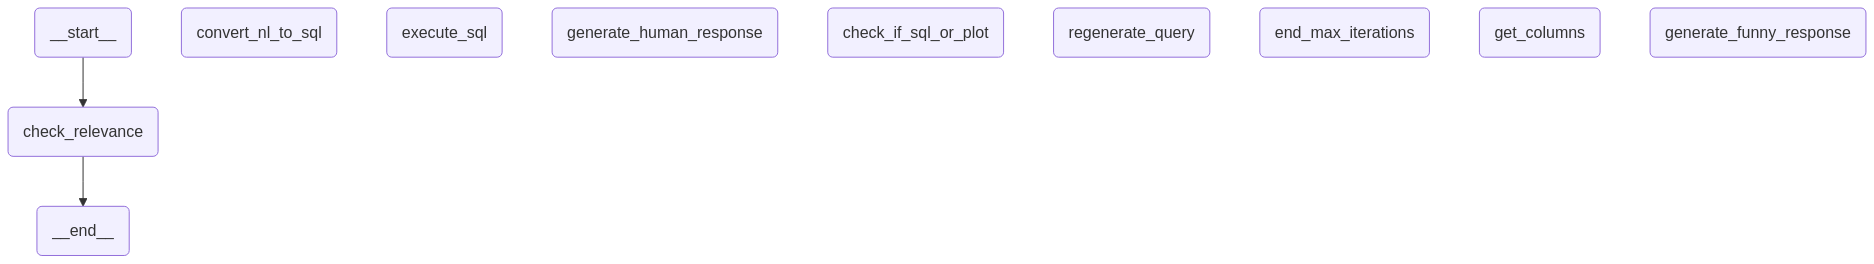

In [33]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [34]:
question = "Create a bar plot that shows the number of passengers, grouped by 20 year age buckets."
result: dict[str, dict[str, Any]] = app.invoke({"question": question, "attempts": 0}, config={})
if result.get("meant_as_query", False):
    # if the SQL query was executed successfully, print the result
    print("Result:", result["sql_query_info"]["query_result"])
else:
    # if the plot was generated successfully, show the plot that was returned
    result["plot_query_info"]["result"].show()
# else:
#     print(result)
#     print("Something went wrong along the way! Try again.")

Checking relevance of the question: Create a bar plot that shows the number of passengers, grouped by 20 year age buckets.


/Users/patrickwalsh/dev/dataly-backend/.venv/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1673: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


Relevance determined: relevant
Checking if the question requires an SQL query or a plot: Create a bar plot that shows the number of passengers, grouped by 20 year age buckets.


/Users/patrickwalsh/dev/dataly-backend/.venv/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1673: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


MEANT AS QUERY:  False
Determined type: False
Convert natural language to SQL
Converting question to SQL: Create a bar plot that shows the number of passengers, grouped by 20 year age buckets.


/Users/patrickwalsh/dev/dataly-backend/.venv/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1673: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


Generated SQL query: SELECT FLOOR(Age / 20) * 20 AS age_group, COUNT(*) AS num_passengers FROM memory.titanic GROUP BY FLOOR(Age / 20) * 20 ORDER BY age_group
Executing SQL query: SELECT FLOOR(Age / 20) * 20 AS age_group, COUNT(*) AS num_passengers FROM memory.titanic GROUP BY FLOOR(Age / 20) * 20 ORDER BY age_group
SUCCESSFUL EXECUTION OF SQL QUERY
Error executing SQL query: Catalog Error: Table with name dataframe does not exist!
Did you mean "pg_database"?

LINE 1: CREATE TABLE memory.transformation_4504 AS SELECT * FROM dataframe
                                                                 ^


CatalogException: Catalog Error: Table with name transformation_4504 does not exist!
Did you mean "titanic"?

In [ ]:
print(insightly.get_schema())

Table name: titanic
PassengerId BIGINT, Survived BIGINT, Pclass BIGINT, Name VARCHAR, Sex VARCHAR, Age DOUBLE, SibSp BIGINT, Parch BIGINT, Ticket VARCHAR, Fare DOUBLE, Cabin VARCHAR, Embarked VARCHAR

